In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
import imp
import sys
sys.path.append('/home/robin/Projects/INM6/elephant')
sys.path.append('/home/robin/Projects/INM6/python-neo')
from elephant.spike_train_surrogates import * 
from elephant.statistics import mean_firing_rate, cv, isi
import seaborn as sns
from quantities import Hz, ms
from scipy.linalg import eigh
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())
rc('text', usetex=True)

In [29]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

#### Load functions for validation tools and visualization

In [30]:
%%capture
dist = imp.load_source('*', './validation/dist.py')
matstat = imp.load_source('*', './validation/matrix.py')
testdata = imp.load_source('*', './validation/test_data.py')
vizi = imp.load_source('*', '../INM6/Tasks/viziphant/plots/generic.py')

data_path = '/home/robin/Projects/ValidationTools'
nest_path = data_path + "/sim_data/NEST_data"
spinnaker_path = data_path + "/sim_data/SpiNNaker_data"

# Number of spiketrains:
N = 100

#### Load spiketrains from simulation

spiketrain_list_1 = testdata.load_data(nest_path, ['spikes_L4'], N)[0][0]

spiketrain_list_2 = testdata.load_data(spinnaker_path, ['spikes_L4'], N)[0][0]

#### ...or generate custom spiketrains

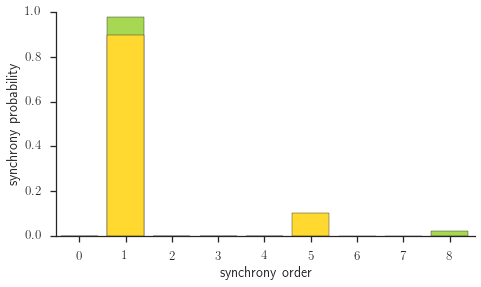

In [36]:
sns.set_context('talk')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7.5,4))
ax.bar(np.arange(9)-0.4,[0, .98, 0, 0, 0, 0, 0, 0, 0.02], color=sns.color_palette('Set2')[4])
ax.bar(np.arange(6)-0.4,[0, .9, 0, 0, 0, 0.1], color=sns.color_palette('Set2')[5])
# ax.bar([2],[0.05], color=sns.color_palette('Set2')[2], alpha=.5)
ax.set_xlim(-0.5,8.54)
ax.set_ylim(0, 1)
ax.set_xlabel('synchrony order')
ax.set_ylabel('synchrony probability')
ax.set_xticks(np.arange(9))
sns.despine()
# plt.savefig('/home/robin/Sciebo/Poster/images/amplitude_dist.eps')

In [38]:
rate = 10*Hz
T = 100000*ms
binsize = 2.*ms
B = T/binsize
A_size = [8, 5]
sync_prob_assembly = [0.02, 0.1]

spiketrain_list_1 = testdata.test_data(size=N, 
                                       corr=sync_prob_assembly, 
                                       t_stop=T, 
                                       rate=rate, 
                                       assembly_sizes=A_size,
                                       method="CPP", 
                                       bkgr_corr=0.0,
                                       shuffle=False)
                                       #shuffle_seed=42)

nbr_of_pairs = [size * (size-1) / 2 for size in A_size]
pw_synchrony = [testdata.transform_sync_prob(syprob, size, rate, T, B, A_size_1=2) 
                for syprob, size in zip(sync_prob_assembly, A_size)]
print pw_synchrony
if 2*sum(nbr_of_pairs) > N:
    print "Warning: More than {} neurons needed for equivalence correlations".format(N)

spiketrain_list_2 = testdata.test_data(size=N, 
                                       corr=[pw_synchrony[0]] * nbr_of_pairs[0] 
                                          + [pw_synchrony[1]] * nbr_of_pairs[1], 
                                       t_stop=T, 
                                       rate=rate, 
                                       assembly_sizes=[2] * sum(nbr_of_pairs),
                                       method="CPP", 
                                       bkgr_corr=0.00,
                                       shuffle_seed=42)

for sts in spiketrain_list_1[:A_size[0]]:
    sts.annotations['assembly']='B'
for sts in spiketrain_list_1[A_size[0]:sum(A_size)]:
    sts.annotations['assembly']='A'
for sts in spiketrain_list_2:
    sts.annotations['assembly']='0'

[array(0.0794472387847948), array(0.22056400443261706)]


#### Rasterplots

(0, 10000)

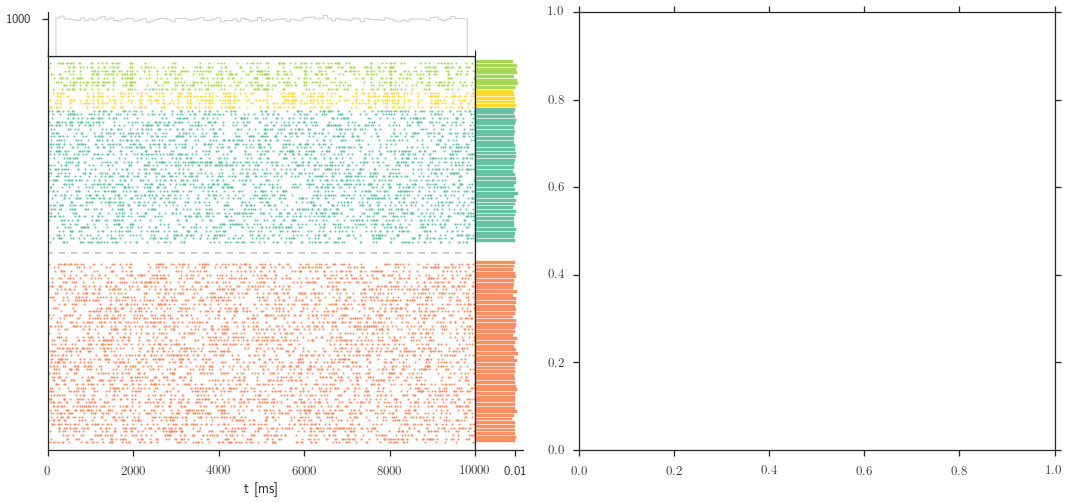

In [46]:
sns.set(style='ticks', palette='Set2', context='talk')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
fig.tight_layout()

assembly_colors = [sns.color_palette()[1],sns.color_palette()[0], sns.color_palette()[5], sns.color_palette()[4]]

__ = vizi.rasterplot([spiketrain_list_2[:50], spiketrain_list_1[:50]], ax=ax[0], palette=assembly_colors, key_list=['assembly'],
                     colorkey='assembly', pophist_mode='total', context='talk', groupingdepth=1, spacing=5)
# __ = vizi.rasterplot(spiketrain_list_2, ax=ax[1], palette=(['r']), context='talk')
ax[0].set_xlim(0,10000)

### Compare distributions 
##### of CVs, firing rates, correlation coefficients, ...

In [1]:
def func(sts):
    ccs = matstat.corr_matrix(sts,  binsize=2*ms).flatten()   
    ccs = np.delete(ccs, np.where(ccs == 1)[0])
    return ccs
    
dist_sample_1 = func(spiketrain_list_1)

dist_sample_2 = func(spiketrain_list_2)


vine_mat = testdata.vine(N, matstat.corr_matrix(spiketrain_list_1,  binsize=2*ms))
vine_ccs = vine_mat.flatten()
dist_sample_3 = np.delete(vine_ccs, np.where(vine_ccs == 1)[0])

NameError: name 'spiketrain_list_1' is not defined

#### Effect Size (Moment Matching)

In [12]:
from numpy import mean, var
from scipy.stats import skew, kurtosis, moment

loggy=False
alt_var = (np.var(dist_sample_1) + np.var(dist_sample_2)) / 2.


print "Mean"
dist.effect_size(dist_sample_1, dist_sample_2, true_var=alt_var, comparison=mean, bias_correction=True, 
                 log_scale=loggy)
print "Variance"
dist.effect_size(dist_sample_1, dist_sample_2, true_var=None, comparison=var, bias_correction=True,
                 comparison_args={'ddof':1}, log_scale=loggy)
print "Skewness"
dist.effect_size(dist_sample_1, dist_sample_2, true_var=None, comparison=moment, bias_correction=True,
                 comparison_args={'moment':3}, dof=1, log_scale=loggy)
print "Kurtosis"
dist.effect_size(dist_sample_1, dist_sample_2, true_var=None, comparison=moment, bias_correction=True,
                 comparison_args={'moment':4}, dof=1, log_scale=loggy);
print "Tail Asymmetry"
dist.effect_size(dist_sample_1, dist_sample_2, true_var=None, comparison=moment, bias_correction=True,
                 comparison_args={'moment':5}, dof=1, log_scale=loggy);
print "Higher Tail Weights"
dist.effect_size(dist_sample_1, dist_sample_2, true_var=None, comparison=moment, bias_correction=True,
                 comparison_args={'moment':6}, dof=1, log_scale=loggy);

Mean

	Effect Size = 0.000469 (+- 0.000005)
	Confidence Interval (95%) = [0.000464 .. 0.000473]

Variance

	Effect Size = 0.00182 (+- 0.00002)
	Confidence Interval (95%) = [0.00180 .. 0.00184]

Skewness

	Effect Size = 0.000734 (+- 0.000007)
	Confidence Interval (95%) = [0.000727 .. 0.000742]

Kurtosis

	Effect Size = 0.000304 (+- 0.000003)
	Confidence Interval (95%) = [0.000301 .. 0.000307]

Tail Asymmetry

	Effect Size = 0.000128 (+- 0.000001)
	Confidence Interval (95%) = [0.000127 .. 0.000129]

Higher Tail Weights

	Effect Size = 0.0000536 (+- 0.0000005)
	Confidence Interval (95%) = [0.0000531 .. 0.0000542]



#### Bayesian Estimation

import best
import best.plot
from pymc import MCMC

model = best.make_model({'sample1':dist_sample_1,'sample2':dist_sample_2},
                        separate_nu=False)

M = MCMC(model)
M.sample(iter=110000, burn=10000)

sns.set(style='ticks', palette='Set2', context='talk')

best.plot.make_figure(M);

#### Show Distribution

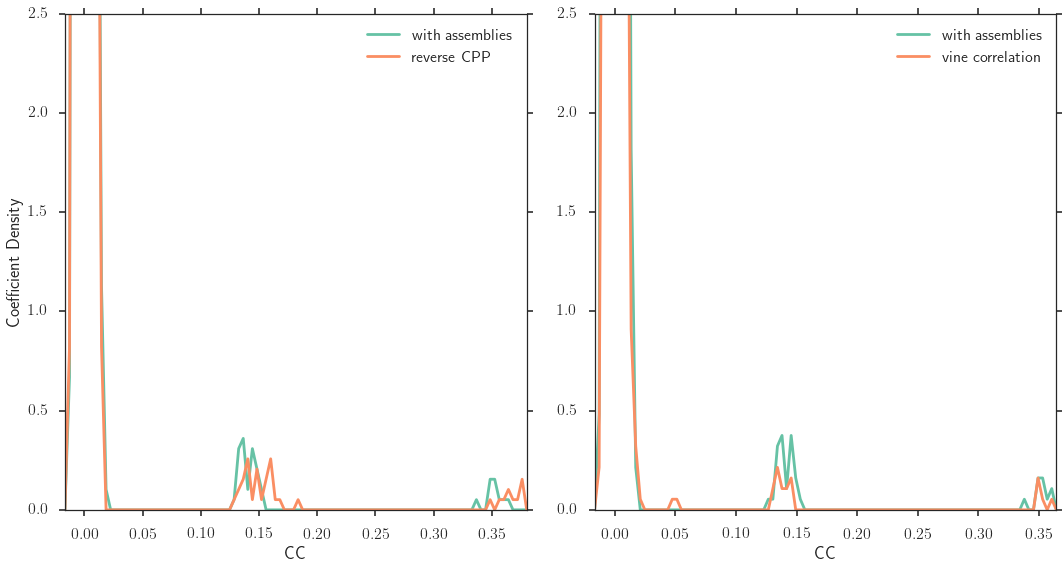

In [13]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
fig.tight_layout()

_ = dist.show(dist_sample_1, dist_sample_2, bins=100, ax=ax[0])        
ax[0].legend(['with assemblies', 'reverse CPP'])
ax[0].set_ylabel('Coefficient Density')
ax[0].set_xlabel('CC')
ax[0].set_ylim(0,2.5);

_ = dist.show(dist_sample_1, dist_sample_3, bins=100, ax=ax[1])        
ax[1].legend(['with assemblies', 'vine correlation'])
ax[1].set_xlabel('CC')
ax[1].set_ylim(0,2.5);

#### Kullback-Leibler Divergence

$$ D_\mathrm{KL}(P||Q) =\sum_{i} P(i) \log_2 \frac{P(i)}{Q(i)} = H(P,Q) - H(P)$$
$ $

The KL-Divergence is a measure of difference between two distribution based on entropy.

When $P$ can be regarded as reference, $D_\mathrm{KL}$ is the amount of information lost when substituting $Q$ for $P$. Consequently this measure is asymetric.

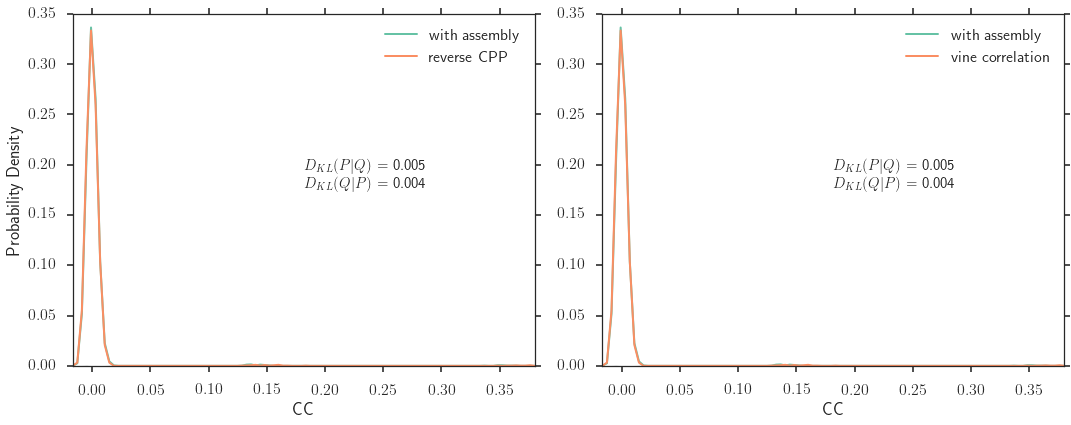

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.tight_layout()

DKL, DKL_inv = dist.KL_test(dist_sample_1, dist_sample_2, ax=ax[0], bins=100, mute=True, xlabel='CC')
ax[0].text(.5, .5, r'$D_{KL}(P\vert Q)$ = ' + '{:.3f}\n'.format(DKL) 
                + r'$D_{KL}(Q\vert P)$ = ' + '{:.3f}'.format(DKL_inv), 
        fontsize=15, transform=ax[0].transAxes)

ax[0].legend(['with assembly', 'reverse CPP'])
ax[0].set_xlabel('CC')

DKL, DKL_inv = dist.KL_test(dist_sample_1, dist_sample_2, ax=ax[1], bins=100, mute=True, xlabel='CC')
ax[1].text(.5, .5, r'$D_{KL}(P\vert Q)$ = ' + '{:.3f}\n'.format(DKL) 
                + r'$D_{KL}(Q\vert P)$ = ' + '{:.3f}'.format(DKL_inv), 
        fontsize=15, transform=ax[1].transAxes)
ax[1].set_ylabel('')
ax[1].legend(['with assembly', 'vine correlation'])
ax[1].set_xlabel('CC');

#### Kolmogorov-Smirnov Distance

$$ D_\mathrm{KS} = \sup | \hat{P}(x) - \hat{Q}(x) | $$
$ $

The KS-Distance measures the maximal vertical distance of the cumulative distributions $\hat{P}$ and $\hat{Q}$. This is a sensitive tool for detecting differences in mean, variance or distribution type. But it can't well detect deviations in the tails of the distributions. A possibily more powerful alternative would be the Cramér-von-Mises Test.

$ $

The null hypothesis that the underlying distributions are identical is rejected when the $D_\mathrm{KS}$ statistic is larger than a critical value $D_\alpha$ or equivalently when the correponding p-value is less than the signficance level $\alpha$.

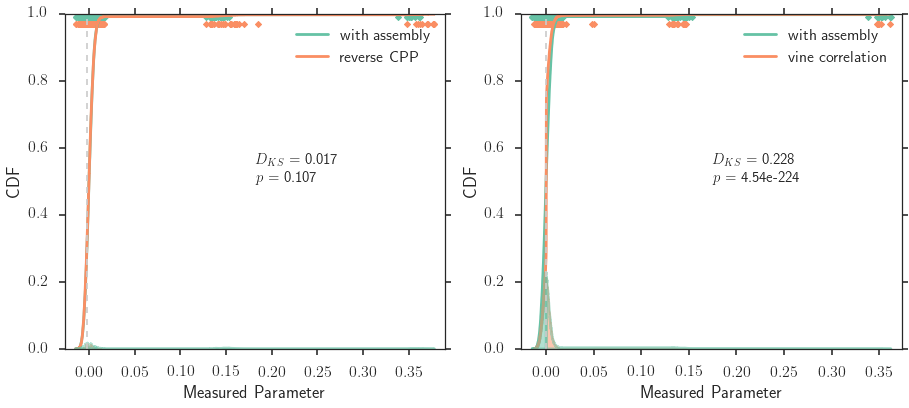

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

DKS, p = dist.KS_test(dist_sample_1, dist_sample_2, ax=ax[0], mute=True)
ax[0].text(.5, .5, r'$D_{KS}$ = ' + '{:.3f}\n'.format(DKS) 
                    + r'$p$ = ' + '{}'.format(dist.to_precision(p,3)), 
                    fontsize=15, transform=ax[0].transAxes)
ax[0].legend(['with assembly', 'reverse CPP'])

DKS, p = dist.KS_test(dist_sample_1, dist_sample_3, ax=ax[1], mute=True)
ax[1].text(.5, .5, r'$D_{KS}$ = ' + '{:.3f}\n'.format(DKS) 
                    + r'$p$ = ' + '{}'.format(dist.to_precision(p,3)), 
                    fontsize=15, transform=ax[1].transAxes)
ax[1].legend(['with assembly', 'vine correlation']);

#### Mann-Whitney U Test

$$ U_i = R_i - \frac{n_i(n_i + 1)}{2}\\ U = min(U_1,U_2) $$

$R_i$: rank sum

$n_i$: sample size

$ $

The Mann-Whitney U is a rank statistic which test the null hypothesis that a random value of sample 1 is equally likely to be larger or a smaller value than a randomly chosen value of sample 2.

$ $

The $U_i$ statistic is in the range of $[0,n_1 n_2]$, and the $U=min(U_1,U_2)$ statistic is in the range of $[0,\frac{n_1 n_2}{2}]$.

$ $

For sample sizes $>20$ $U$ follows approximately a normal distribution. With this assumption a p-value can be inferred. The null hypothesis is consequently rejected when the p-value is less than the significance level.

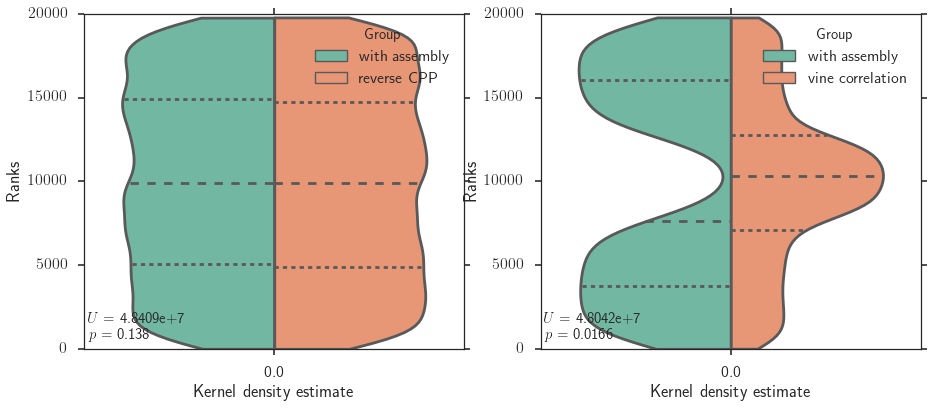

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

U, p = dist.MWU_test(dist_sample_1, dist_sample_2, ax=ax[0], excl_nan=True, mute=True, 
                     sample_names=['with assembly', 'reverse CPP'])
ax[0].text(.01, .03, r'$U$ = ' + '{}\n'.format(dist.to_precision(U,5)) 
                      + r'$p$ = ' + '{}'.format(dist.to_precision(p,3)), 
                       fontsize=15, transform=ax[0].transAxes)

U, p = dist.MWU_test(dist_sample_1, dist_sample_3, ax=ax[1], excl_nan=True, mute=True, 
                     sample_names=['with assembly', 'vine correlation'])
ax[1].text(.01, .03, r'$U$ = ' + '{}\n'.format(dist.to_precision(U,5)) 
                      + r'$p$ = ' + '{}'.format(dist.to_precision(p,3)), 
                       fontsize=15, transform=ax[1].transAxes);

### Compare the correlation matrices

#### Heatmap

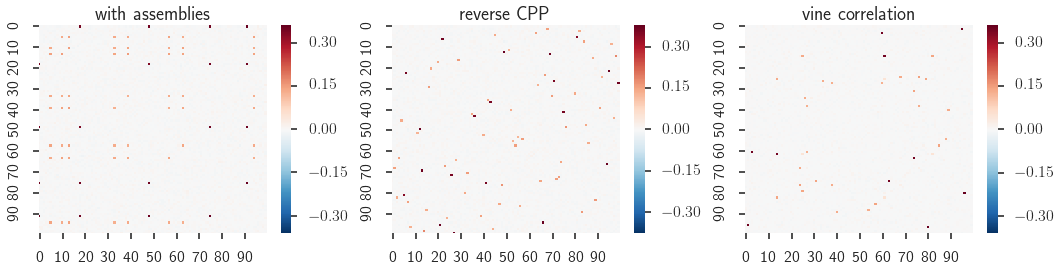

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
fig.tight_layout()

corr_matrix_1 = matstat.corr_matrix(spiketrain_list_1)
corr_matrix_2 = matstat.corr_matrix(spiketrain_list_2)
corr_matrix_3 = vine_mat

ax[0].set_title('with assemblies')
matstat.plot_matrix(corr_matrix_1, ax[0], remove_autocorr=True)
ax[1].set_title('reverse CPP')
matstat.plot_matrix(corr_matrix_2, ax[1], remove_autocorr=True)
ax[2].set_title('vine correlation')
matstat.plot_matrix(corr_matrix_3, ax[2], remove_autocorr=True)

#### Eigenvalue distribution & spectra


Redundancy = 0.02 


Redundancy = 0.02 


Redundancy = 0.01 



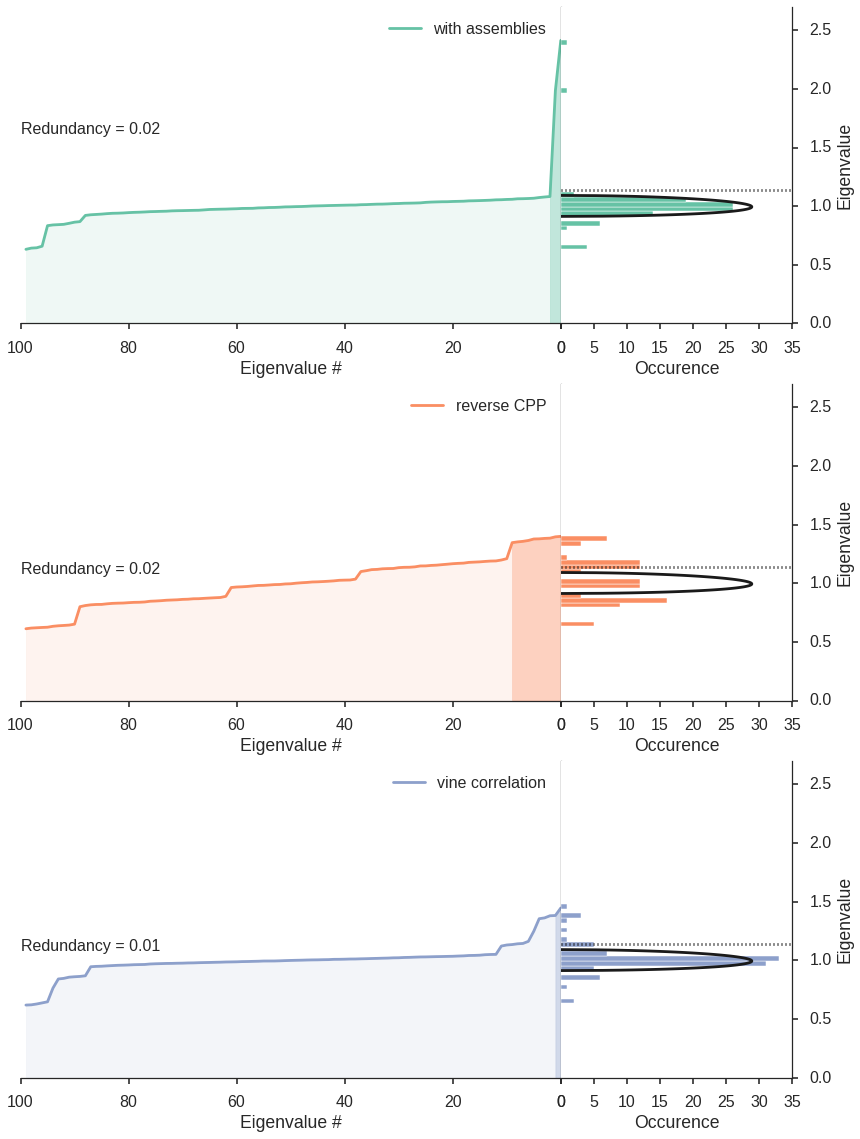

In [18]:
from matplotlib import rc
rc('text', usetex=False)
EWs_1, EVs_1 = eigh(corr_matrix_1)
EWs_2, EVs_2 = eigh(corr_matrix_2)
EWs_3, EVs_3 = eigh(corr_matrix_3)

sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,16))
fig.tight_layout()
ymax = 2.7

edges, axhist1, tw_bound1 = matstat.eigenvalue_significance(EWs_1, ax[0], bins=44, N=N, B=B, ylim=(0,ymax), 
                                     color=sns.color_palette()[0], mute=True)
xmax1 = axhist1.get_xlim()
R1 = matstat.redundancy(EWs_1)
ax[0].text(0, .6, 'Redundancy = ' + '{:.2f}'.format(R1), 
           fontsize=16, transform=ax[0].transAxes)
ax[0].legend(['with assemblies'])



__, axhist2, tw_bound2 = matstat.eigenvalue_significance(EWs_2, ax[1], bins=edges, N=N, B=B, ylim=(0,ymax), 
                                     color=sns.color_palette()[1], mute=True)
xmax2 = axhist2.get_xlim()
R2 = matstat.redundancy(EWs_2)
ax[1].text(0, .4, 'Redundancy = ' + '{:.2f}'.format(R2), 
           fontsize=16, transform=ax[1].transAxes)
ax[1].legend(['reverse CPP'])



__, axhist3, tw_bound3 = matstat.eigenvalue_significance(EWs_3, ax[2], bins=edges, N=N, B=B, ylim=(0,ymax), 
                                     color=sns.color_palette()[2], mute=True)
xmax3 = axhist3.get_xlim()
R3 = matstat.redundancy(EWs_3)
ax[2].text(0, .4, 'Redundancy = ' + '{:.2f}'.format(R3), 
           fontsize=16, transform=ax[2].transAxes)
ax[2].legend(['vine correlation'])


axhist1.set_xlim((0,max(xmax1[1],xmax2[1],xmax3[1])))
axhist2.set_xlim((0,max(xmax1[1],xmax2[1],xmax3[1])))
axhist2.set_xlim((0,max(xmax1[1],xmax2[1],xmax3[1])));

#### Show eigenvectors

In [19]:
if N < 17:
    colormap = [37,37,30,34,32,31,33,36,35] + [47,40,44,42,41,43,46,45]
    matstat.print_eigenvectors(EVs_1, EWs_1, pc_nbr_1, colormap=colormap)
    matstat.print_eigenvectors(EVs_2, EWs_2, pc_nbr_2, colormap=colormap)

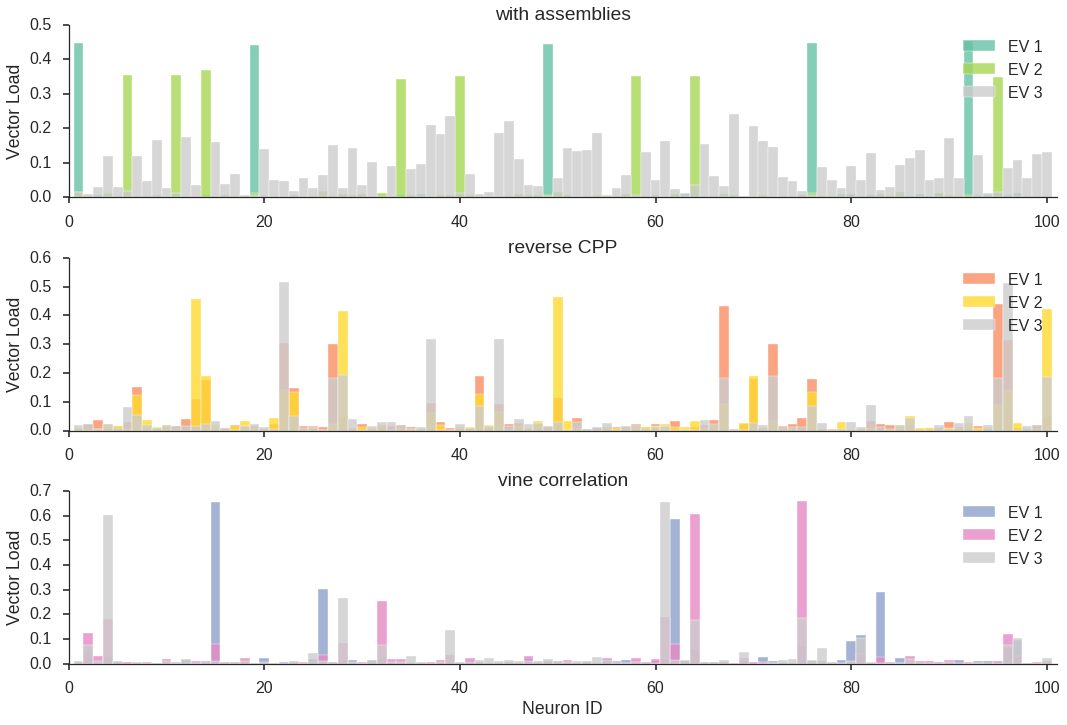

In [20]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,10))
fig.tight_layout()
palette = sns.color_palette()

def plot_EVs(EVs, ax, color):
    for i, color_inst in enumerate(color):
        ax.bar(np.arange(100)+.5, np.absolute(EVs.T[::-1])[i], 1., edgecolor='w', label='EV {}'.format(i+1),
              color=color_inst, alpha=.8)
    ax.set_xlim(0,101)
    ax.set_ylabel('Vector Load')
    ax.legend()

ax[0].set_title('with assemblies')
plot_EVs(EVs_1, ax[0], [palette[0], palette[4], '0.8'])
ax[1].set_title('reverse CPP')
plot_EVs(EVs_2, ax[1], [palette[1], palette[5], '0.8'])
ax[2].set_title('vine correlation')
plot_EVs(EVs_3, ax[2], [palette[2], palette[3], '0.8'])
ax[2].set_xlabel('Neuron ID')

sns.despine()

#### Angles between eigenspaces

In [21]:
# nbr_of_pcs = min(pc_nbr_1, pc_nbr_2)
nbr_of_pcs = 2
_ = matstat.EV_angles(EVs_1[:, -nbr_of_pcs:], EVs_2[:, -nbr_of_pcs:])

_ = matstat.EV_angles(EVs_1[:, -nbr_of_pcs:], EVs_3[:, -nbr_of_pcs:])

_ = matstat.EV_angles(EVs_2[:, -nbr_of_pcs:], EVs_3[:, -nbr_of_pcs:])


Angles between the eigenvectors
	83.02°
	81.47°

Angle between eigenspaces
	89.53°

Angles between the eigenvectors
	88.99°
	75.26°

Angle between eigenspaces
	89.84°

Angles between the eigenvectors
	85.32°
	83.33°

Angle between eigenspaces
	89.86°


#### Detect Assemblies

In [22]:
print "\033[36mSample with assemblies\033[0m\n"
__, corr_order_1 = matstat.detect_assemblies(EVs_1, EWs_1, detect_by=.2, EW_lim=tw_bound1, sort=True, jupyter=True)

print "\033[36mSample reverse CPP\033[0m\n"
__, corr_order_2 = matstat.detect_assemblies(EVs_2, EWs_2, detect_by=.2, EW_lim=tw_bound2, sort=True, jupyter=True)

print "\033[36mSample vine correlation\033[0m\n"
__, corr_order_3 = matstat.detect_assemblies(EVs_3, EWs_3, detect_by=.2, EW_lim=tw_bound3, sort=True, jupyter=True)

Sample with assemblies

Assembly 1, eigenvalue 2.41, size 5
Neuron ID:	91	75	 0	48	18		Norm
Load:	0.45	0.45	0.45	0.44	0.44		1.00

Assembly 2, eigenvalue 1.99, size 8
Neuron ID:	13	10	 5	63	57	39	94	33		Norm
Load:	0.37	0.35	0.35	0.35	0.35	0.35	0.35	0.34		1.00

Sample reverse CPP

Assembly 1, eigenvalue 1.40, size 6
Neuron ID:	94	66	95	21	71	26		Norm
Load:	0.44	0.43	0.31	0.30	0.30	0.30		0.87

Assembly 2, eigenvalue 1.40, size 4
Neuron ID:	49	12	99	27		Norm
Load:	0.47	0.46	0.42	0.42		0.88

Assembly 3, eigenvalue 1.38, size 4
Neuron ID:	21	95	43	36		Norm
Load:	0.52	0.51	0.32	0.32		0.85

Assembly 4, eigenvalue 1.38, size 9
Neuron ID:	66	94	22	 6	12	49	69	13	71		Norm
Load:	0.34	0.33	0.29	0.29	0.27	0.27	0.24	0.23	0.20		0.83

Assembly 5, eigenvalue 1.38, size 4
Neuron ID:	13	69	12	49		Norm
Load:	0.49	0.48	0.36	0.35		0.85

Assembly 6, eigenvalue 1.38, size 6
Neuron ID:	 6	22	 5	81	41	75		Norm
Load:	0.45	0.45	0.29	0.29	0.24	0.24		0.83

Assembly 7, eigenvalue 1.36, size 7
Neuron ID:	41	75	99	27	9

#### Show Assemblies in Correlation Matrix

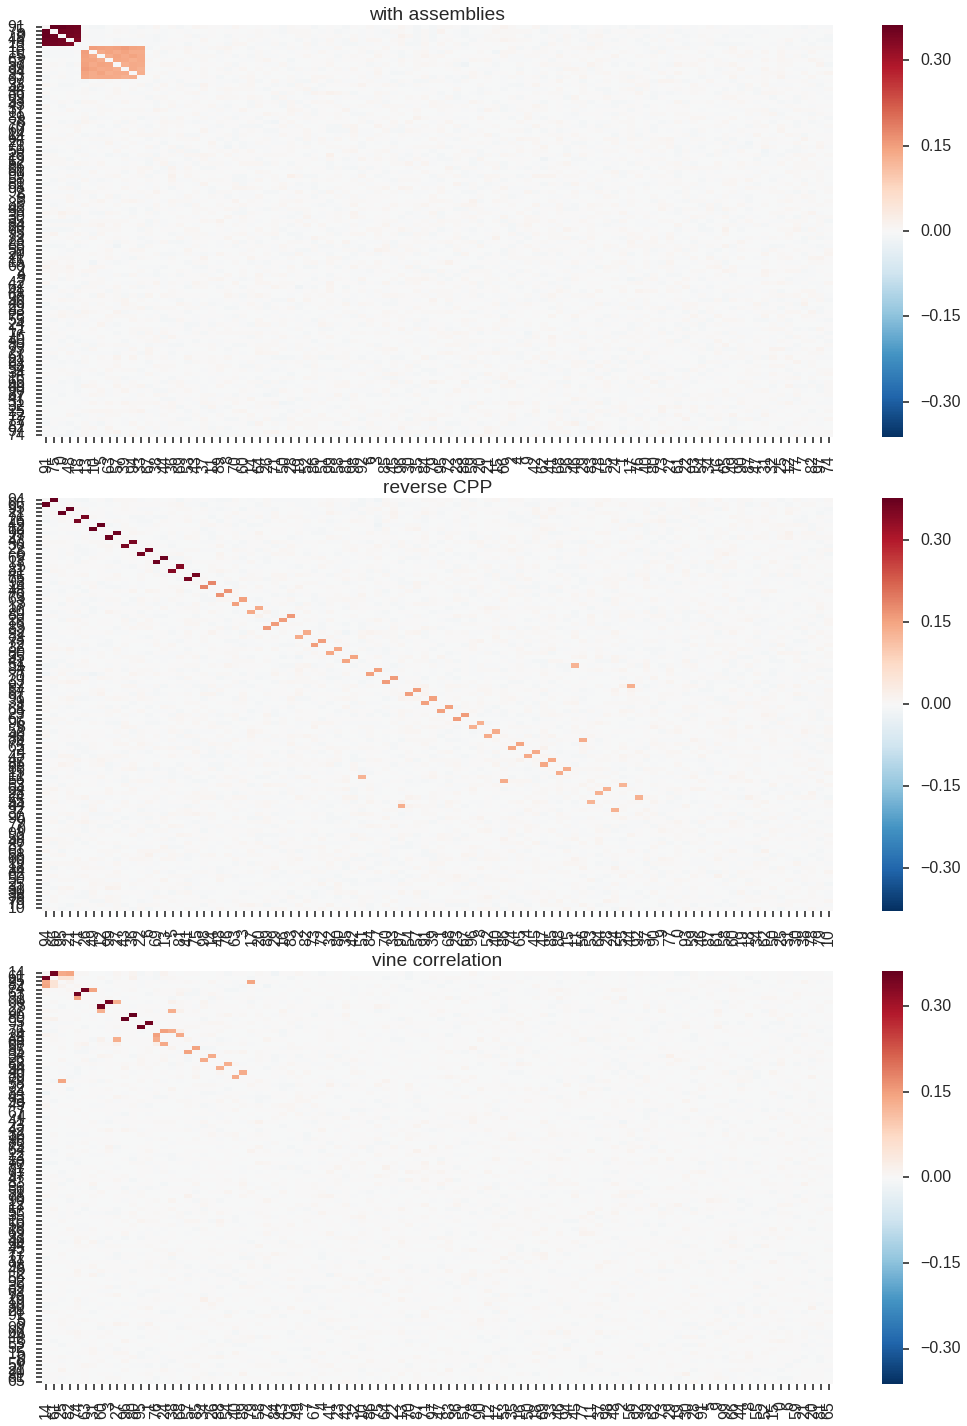

In [23]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,20))
fig.tight_layout()

ordered_matrix_1 = corr_matrix_1[corr_order_1, :][:, corr_order_1]
ordered_matrix_2 = corr_matrix_2[corr_order_2, :][:, corr_order_2]
ordered_matrix_3 = corr_matrix_3[corr_order_3, :][:, corr_order_3]

ax[0].set_title('with assemblies')
matstat.plot_matrix(ordered_matrix_1, ax[0], labels=corr_order_1, remove_autocorr=True)
ax[1].set_title('reverse CPP')
matstat.plot_matrix(ordered_matrix_2, ax[1], labels=corr_order_2, remove_autocorr=True)
ax[2].set_title('vine correlation')
matstat.plot_matrix(ordered_matrix_3, ax[2], labels=corr_order_3, remove_autocorr=True)